In [ ]:
:orphan:

# Calibration and Optimization with Spatially-varying Data

_written by Jaren N. Ashcraft_

Note that this demo is in progress, and as such does not appear on katsu.readthedocs.io. 

To meet the challenge of spatially-resolved Mueller polarimeter measurements, we need to be able to calibrate the polarimeter on a pixel-by-pixel basis. This eliminates one of the greatest sources of averaging down uncertainty in the measurement of a devices Mueller matrix, but is nonetheless important for precision polarization aberration measurement.

Here we aim to leverage Katsu's ability to do spatially-broadcasted calculations to try and calibrate spatial anisotropies in the Dual-rotating-retarder Mueller Polarimeter. This is done entirely in simulation for a demonstration, but we hope to demonstrate this in the laboratory as well. 

Truly performing this calibration on a pixel-by-pixel basis is a high dimenisonal problem. However, we can reduce the dimensionality of the spatial anisotropy by expressing the retardance of the waveplates as a basis expansion.

$$\delta(r, \theta)_{PSG/PSA} = \sum_{i=0}^N a_{i} Z_{i} (r, \theta)$$

Here, we will fit to coefficients $a_i$ of a polynomial $Z_i$ basis. The convenience of expressing the retardance in a functional form in polar coordinates is because we can rotate them quite trivially. For example, if the polarization state generator is rotated an angle $\phi$, the basis expansion changes very simply.

$$\delta(r, \theta + \phi)_{PSG} = \sum_{i=0}^N a_{i} Z_{i} (r, \theta + \phi)$$

Below, we demonstrate such a rotation using _prysm_'s helpful library of polynomials.

In [1]:
import matplotlib.pyplot as plt

from prysm.coordinates import make_xy_grid, cart_to_polar
from prysm.polynomials import noll_to_nm, zernike_nm_sequence, sum_of_2d_modes
from prysm.geometry import circle

from katsu.mueller import (
    linear_diattenuator,
    linear_retarder,
    linear_polarizer
)

from katsu.katsu_math import np, set_backend_to_jax
import numpy as tnp

# Just a plotting macro
def plot_square(x,n=4,vmin=None,vmax=None):
    k = 1
    plt.figure(figsize=[10,10])
    for i in range(n):
        for j in range(n):
            plt.subplot(n,n,k)
            plt.imshow(x[..., i, j], vmin=vmin, vmax=vmax, cmap='RdBu_r')
            plt.colorbar()
            k += 1
    plt.show()

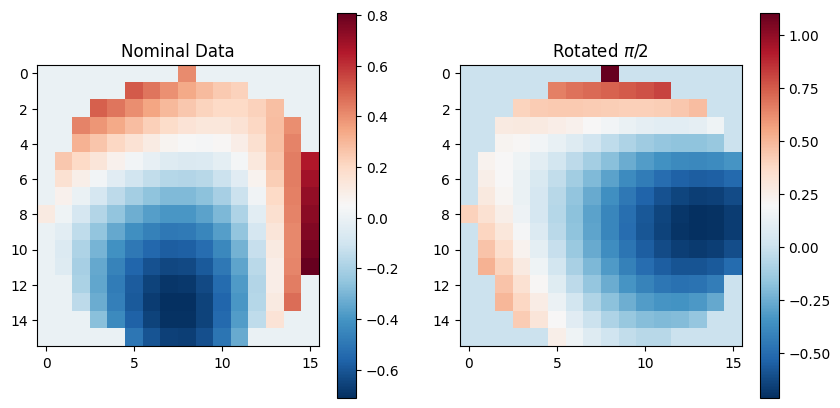

In [2]:
ROTATION_ANGLE = np.pi / 2
NPIX = 16

# set up coordinates
x, y = make_xy_grid(NPIX, diameter=1)
r, t = cart_to_polar(x, y)

# set up Zernike polynomial basis
nms = [noll_to_nm(i) for i in range(1,11)]
basis = list(zernike_nm_sequence(nms, r, t))
basis_rotated = list(zernike_nm_sequence(nms, r, t + ROTATION_ANGLE))

# generate the data
A = circle(0.5, r)
coeffs = tnp.random.random(len(basis))
data = sum_of_2d_modes(basis, coeffs)
data_rotated = sum_of_2d_modes(basis_rotated, coeffs)

# plot the data
plt.figure(figsize=[10,5])
plt.subplot(121)
plt.title('Nominal Data')
plt.imshow(data * A, cmap='RdBu_r')
plt.colorbar()
plt.subplot(122)
plt.title('Rotated '+r'$\pi/2$')
plt.imshow(data_rotated * A, cmap='RdBu_r')
plt.colorbar()
plt.show()

A simple constant to the addition accomplishes the rotation. Next, we show how to apply spatially-varying data to `Katsu` linear retarders

In [3]:
scale = 100
NOMINAL_RETARDANCE = np.pi / 4
NOMINAL_ANGLE = 0
coeffs_angle = tnp.random.random(len(basis)) / scale
coeffs_retardance = tnp.random.random(len(basis)) / scale

# Use prysm to construct array
angle = sum_of_2d_modes(basis, coeffs_angle) * A
retardance = sum_of_2d_modes(basis, coeffs_retardance) * A

# A quarter-wave plate with error
psg_ret = linear_retarder(NOMINAL_ANGLE + angle, NOMINAL_RETARDANCE + np.pi/4 + retardance, shape=basis[0].shape)

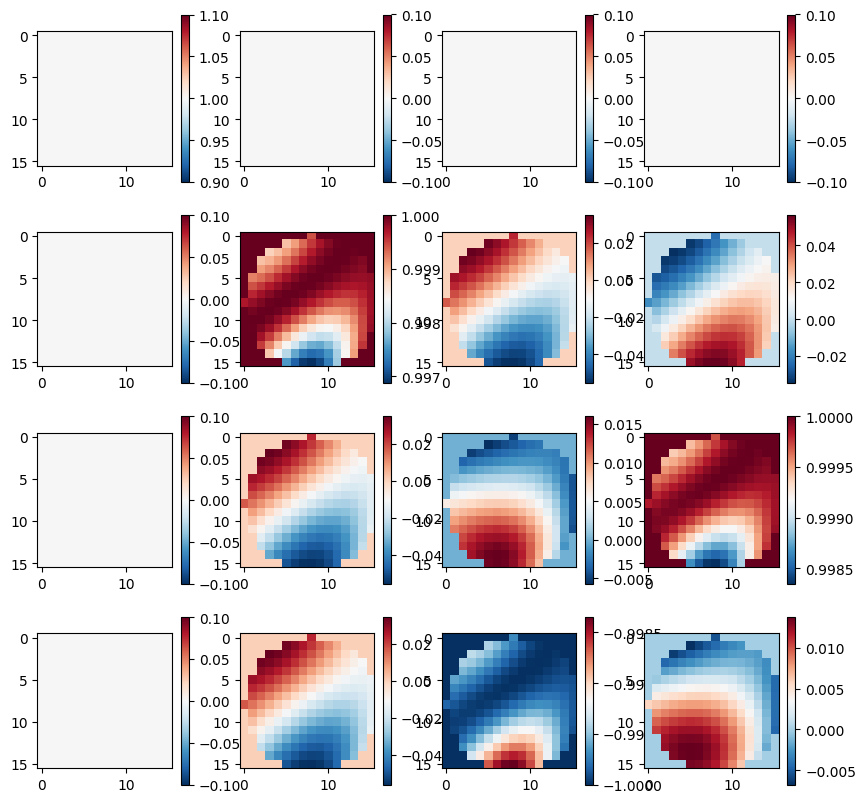

In [4]:
vlim = None
plot_square(psg_ret, n=4, vmin=vlim, vmax=vlim)

Now let's apply a rotation, and we see a fairly substantial change in the Mueller Matrix! Note that the two inner on-diagonal elements have switched.

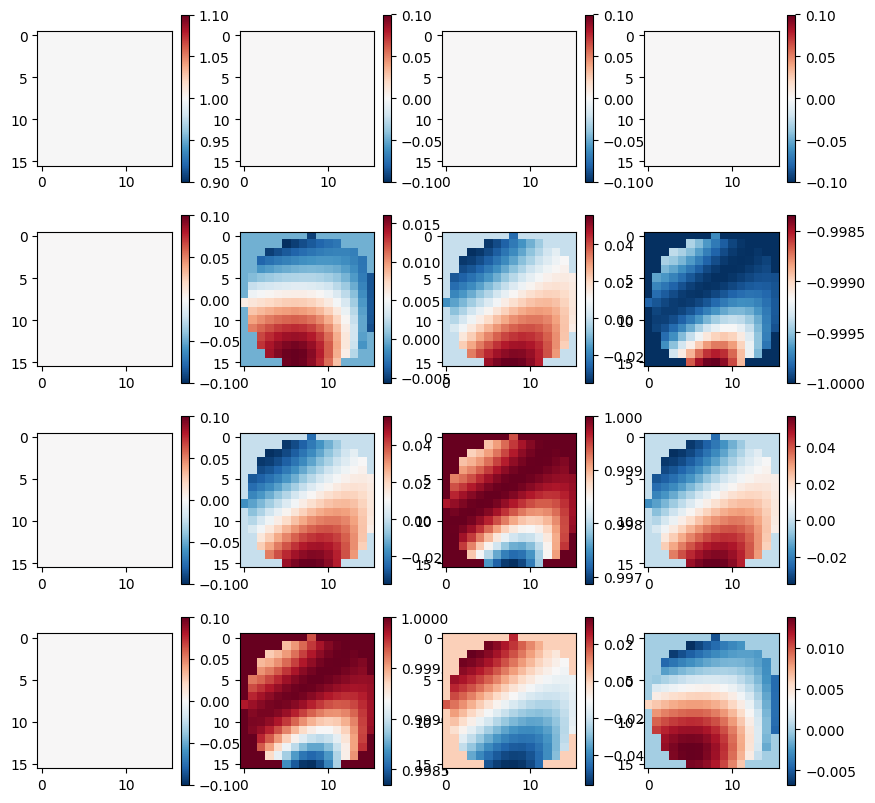

In [5]:
ROTATION = np.pi / 4

psg_ret_rotated = linear_retarder(NOMINAL_ANGLE + ROTATION + angle, NOMINAL_RETARDANCE + np.pi/4 + retardance, shape=basis[0].shape)

plot_square(psg_ret_rotated, n=4, vmin=vlim, vmax=vlim)

Next we construct a forward model with some spatially-varying retarders. For simplicity, we assume that the polarizers are homogeneous, and that all of the polarimeter optics (2 waveplates, 2 polarizers) are aligned at the beginning of the experiment.

In [6]:
set_backend_to_jax()
import numpy as tnp

In [7]:
# Set up truth
coeffs_angle_psg = tnp.random.random(len(basis)) / scale
coeffs_retardance_psg = tnp.random.random(len(basis)) / scale

coeffs_angle_psa = tnp.random.random(len(basis)) / scale
coeffs_retardance_psa = tnp.random.random(len(basis)) / scale

# construct retarders
angle_psg = sum_of_2d_modes(basis, coeffs_angle_psg) * A
retardance_psg = sum_of_2d_modes(basis, coeffs_retardance_psg) * A
psg_ret = linear_retarder(NOMINAL_ANGLE + angle_psg, NOMINAL_RETARDANCE + np.pi/4 + retardance_psg, shape=basis[0].shape)

angle_psa = sum_of_2d_modes(basis, coeffs_angle_psa) * A
retardance_psa = sum_of_2d_modes(basis, coeffs_retardance_psa) * A
psa_ret = linear_retarder(NOMINAL_ANGLE + angle_psa, NOMINAL_RETARDANCE + np.pi/4 + retardance_psa, shape=basis[0].shape)

# construct polarizers
psg_pol = linear_diattenuator(0, 0, shape=basis[0].shape)
psa_pol = linear_diattenuator(0, 0, shape=basis[0].shape)

We begin by simulating a calibration run, where we perform an Air measurement.

In [8]:
N_MEASUREMENTS = 75
ANGULAR_RATIO = 5

psg_angles = np.linspace(0, np.pi, N_MEASUREMENTS)
psa_angles = psg_angles * ANGULAR_RATIO

power_measured = []

for psgth, psath in zip(psg_angles, psa_angles):

    # rotate retarders
    psg_ret = linear_retarder(NOMINAL_ANGLE + angle_psg + psgth, NOMINAL_RETARDANCE + np.pi/4 + retardance_psg, shape=basis[0].shape)
    psa_ret = linear_retarder(NOMINAL_ANGLE + angle_psa + psath, NOMINAL_RETARDANCE + np.pi/4 + retardance_psa, shape=basis[0].shape)

    # compute the power
    M_tot = psa_pol @ psa_ret @ psg_ret @ psa_pol

    power = M_tot[..., 0, 0]

    power_measured.append(power)

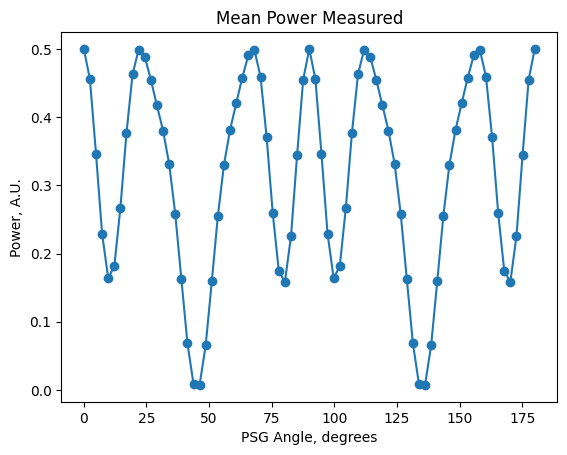

In [9]:
mean_power = np.mean(np.asarray(power_measured), axis=(1, 2))

plt.figure()
plt.plot(np.degrees(psg_angles), mean_power, marker='o')
plt.title('Mean Power Measured')
plt.xlabel('PSG Angle, degrees')
plt.ylabel('Power, A.U.')
plt.show()

Let's get a sense of what the data looks like if we have infinite resolution, hooray simulation!

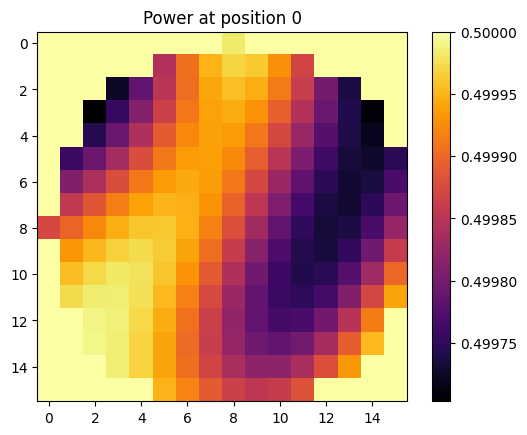

In [10]:
plt.figure()
plt.title('Power at position 0')
plt.imshow(power_measured[0], cmap='inferno')
plt.colorbar()
plt.show()

Now let us try to use `Katsu` to fit to these spatial variations.

## 3. Data Reduction with spatially-varying polarizers
What parameters require optimization? We have 
- $\mathbf{T}_{g}(\mathbf{r}, \mathbf{\theta})$, the minimum transmission of the PSG polarizer
- $\mathbf{\Phi}_{g}(\mathbf{r}, \mathbf{\theta})$, the angle of transmission of the PSG polarizer
- $\mathbf{\Delta}_{g}(\mathbf{r}, \mathbf{\theta})$, the retardance of the PSG retarder
- $\mathbf{\Psi}_{g}(\mathbf{r}, \mathbf{\theta})$, the fast axis of the PSG retarder
- $\mathbf{T}_{a}(\mathbf{r}, \mathbf{\theta})$, the minimum transmission of the PSA polarizer
- $\mathbf{\Phi}_{a}(\mathbf{r}, \mathbf{\theta})$, the angle of transmission of the PSA polarizer
- $\mathbf{\Delta}_{a}(\mathbf{r}, \mathbf{\theta})$, the retardance of the PSA retarder
- $\mathbf{\Psi}_{a}(\mathbf{r}, \mathbf{\theta})$, the fast axis of the PSA retarder
- $\theta_{p,g}$, the angular offset of the PSG polarizer
- $\theta_{r,g}$, the angular offset of the PSG retarder
- $\Theta_{r,g}$, the angular increment of the PSG retarder
- $\theta_{p,a}$, the angular offset of the PSA polarizer
- $\theta_{r,a}$, the angular offset of the PSA retarder
- $\Theta_{r,a}$, the angular increment of the PSA retarder

The bold quantities are of shape $N_{modes}$ and the remaining are individuals. We can pack the gradients by appending them to an array. In total, we need $8 \times N_{modes} + 6$ free parameters

In [11]:
# Set up the optics
coeffs_spatially_varying = tnp.random.random([8, len(basis)]) / 10
theta_pg = 0
theta_rg = 0
Theta_rg = np.radians(10)
theta_pa = np.radians(90)
theta_ra = 0
Theta_ra = np.radians(10)

NMEAS = 26

### PSG Polarizer

In [12]:
psg_pol = linear_polarizer(0 + theta_pg,
                              shape=[*basis[0].shape, NMEAS])

### PSG Retarder

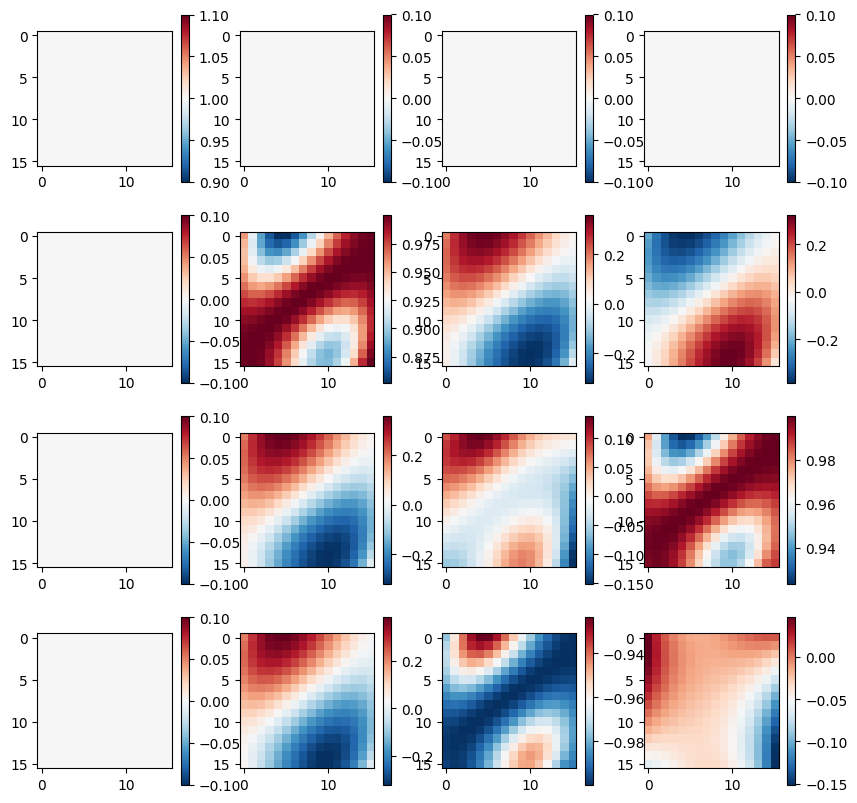

In [13]:
retar_psg_wvp = sum_of_2d_modes(basis, coeffs_spatially_varying[2])
retar_psg_wvp += np.pi / 2
angle_psg_wvp = sum_of_2d_modes(basis, coeffs_spatially_varying[3])

rotations = np.linspace(0, np.radians(180), NMEAS)
rotations = np.broadcast_to(rotations, [*angle_psg_wvp.shape, NMEAS])

angle_psg_wvp = np.broadcast_to(angle_psg_wvp, [NMEAS, *angle_psg_wvp.shape])
angle_psg_wvp = np.moveaxis(angle_psg_wvp, 0, -1)

total_angle = angle_psg_wvp + rotations

retar_psg_wvp = np.broadcast_to(retar_psg_wvp, [NMEAS, *retar_psg_wvp.shape])
retar_psg_wvp = np.moveaxis(retar_psg_wvp, 0, -1)


psg_wvp = linear_retarder(total_angle,
                          retar_psg_wvp,
                          shape=[NPIX, NPIX, NMEAS])
plot_square(psg_wvp[:,:,0], n=4)

### PSA Retarder

(16, 16, 26)


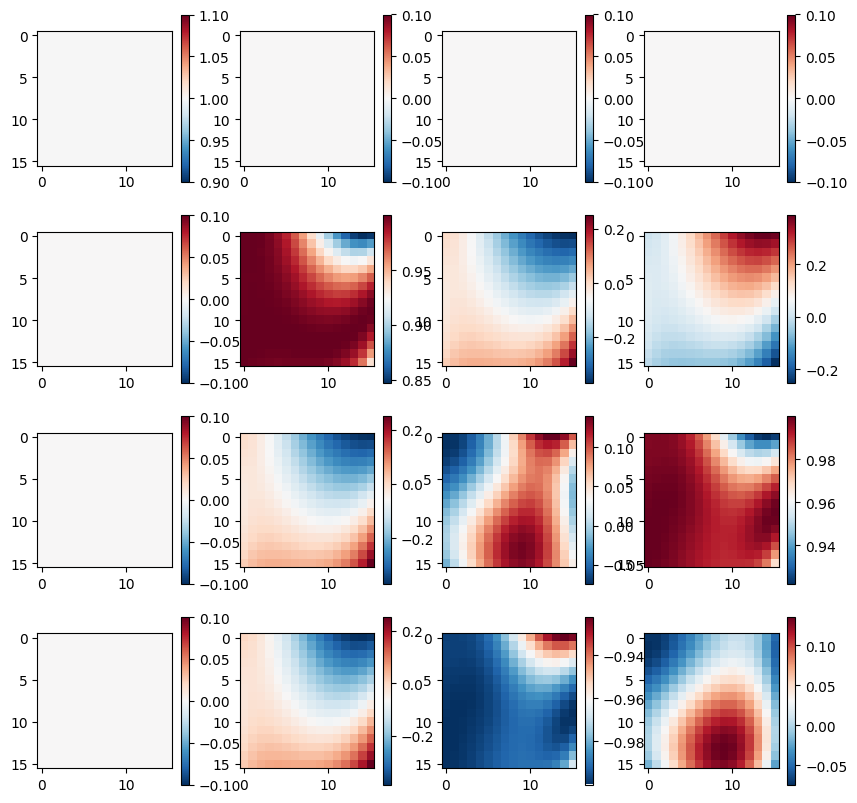

In [14]:
retar_psa_wvp = sum_of_2d_modes(basis, coeffs_spatially_varying[4])
retar_psa_wvp += np.pi / 2
angle_psa_wvp = sum_of_2d_modes(basis, coeffs_spatially_varying[5])

rotations = np.linspace(0, np.radians(180) * 2.5, NMEAS)
rotations = np.broadcast_to(rotations, [*angle_psa_wvp.shape, NMEAS])

angle_psa_wvp = np.broadcast_to(angle_psa_wvp, [NMEAS, *angle_psa_wvp.shape])
angle_psa_wvp = np.moveaxis(angle_psa_wvp, 0, -1)

total_angle = angle_psa_wvp + rotations

retar_psa_wvp = np.broadcast_to(retar_psa_wvp, [NMEAS, *retar_psa_wvp.shape])
retar_psa_wvp = np.moveaxis(retar_psa_wvp, 0, -1)

print(total_angle.shape)

psg_wvp = linear_retarder(total_angle,
                          retar_psa_wvp,
                          shape=[NPIX, NPIX, NMEAS])

psa_wvp = linear_retarder(total_angle, retar_psa_wvp, shape=angle_psa_wvp.shape)
plot_square(psa_wvp[...,0,:,:], n=4)

### PSA Polarizer

In [15]:
psa_pol = linear_polarizer(theta_pa,
                              shape=[*basis[0].shape, NMEAS])

print(psa_pol.shape)
# Create power measurements
power_experiment = (psa_pol @ psa_wvp @ psg_wvp @ psg_pol)[..., 0, 0]

(16, 16, 26, 4, 4)


### The Forward Model

Here we determine the degree to which an air measurtement will suffer from spatial nonuniformities on the optics.

In [22]:
def jax_sum_of_2d_modes(modes, weights):
    modes = np.asarray(modes)
    weights = np.asarray(weights).astype(modes.dtype)

    # dot product of the 0th dim of modes and weights => weighted sum
    return np.tensordot(modes, weights, axes=(0, 0))

def forward_simulate(x):

    ROTATION_RATIO = 2.5
    END_ANGLE_PSG = 180

    # unpack the parameters
    theta_pg = x[0] # Starting angle of the polarizer
    theta_pa = x[1] # Starting angle of the polarizer

    # get spatially varying coefficcients
    coeffs_spatial_ret_psg = x[2: 2 + len(basis)]
    coeffs_spatial_ang_psg = x[2 + 1*len(basis):(2 + 1*len(basis))+len(basis)]
    coeffs_spatial_ret_psa = x[2 + 2*len(basis):(2 + 2*len(basis))+len(basis)]
    coeffs_spatial_ang_psa = x[2 + 3*len(basis):(2 + 3*len(basis))+len(basis)]

    # set up the basis with rotation
    x, y = make_xy_grid(NPIX, diameter=1)
    r, t = cart_to_polar(x, y)

    # set up Zernike polynomial basis
    nms = [noll_to_nm(i) for i in range(len(basis))]

    # the nominal rotations performed
    rotations_psg = np.linspace(0, np.radians(END_ANGLE_PSG), NMEAS)
    rotations_psa = rotations_psg * ROTATION_RATIO

    psg_retardances, psa_retardances = [], []
    psg_fast_axes, psa_fast_axes = [], []

    for rot_psg, rot_psa in zip(rotations_psg, rotations_psa):

        # Get the rotated spatial basis
        basis_psg = np.asarray(list(zernike_nm_sequence(nms, r, t + rot_psg)))
        basis_psa = np.asarray(list(zernike_nm_sequence(nms, r, t + rot_psa)))

        # compute retardances
        psg_retardance = jax_sum_of_2d_modes(basis_psg, coeffs_spatial_ret_psg)
        psa_retardance = jax_sum_of_2d_modes(basis_psa, coeffs_spatial_ret_psa)

        # compute fast axes
        psg_fast_axis = jax_sum_of_2d_modes(basis_psg, coeffs_spatial_ang_psg)
        psa_fast_axis = jax_sum_of_2d_modes(basis_psa, coeffs_spatial_ang_psa)

        # store arrays in list
        psg_retardances.append(psg_retardance)
        psa_retardances.append(psa_retardance)
        psg_fast_axes.append(psg_fast_axis)
        psa_fast_axes.append(psa_fast_axis)

    # get lists as arrays
    psg_retardances = np.asarray(psg_retardances)
    psa_retardances = np.asarray(psa_retardances)
    psg_fast_axes = np.asarray(psg_fast_axes)
    psa_fast_axes = np.asarray(psa_fast_axes)

    # swap axes around
    psg_retardances = np.moveaxis(psg_retardances, 0, -1)
    psa_retardances = np.moveaxis(psa_retardances, 0, -1)
    psg_fast_axes = np.moveaxis(psg_fast_axes, 0, -1)
    psa_fast_axes = np.moveaxis(psa_fast_axes, 0, -1)

    # set up the drrp
    psg_pol = linear_polarizer(theta_pg, shape=[*basis[0].shape, NMEAS])
    psg_wvp = linear_retarder(psg_fast_axes, psg_retardances, shape=[NPIX, NPIX, NMEAS])

    psa_wvp = linear_retarder(psa_fast_axes, psa_retardances, shape=[NPIX, NPIX, NMEAS])
    psa_pol = linear_polarizer(theta_pa, shape=[*basis[0].shape, NMEAS])

    # Create power measurements
    power_measured = (psa_pol @ psa_wvp @ psg_wvp @ psg_pol)[..., 0, 0]

    return power_measured

def loss(x):
    return np.sum((forward_simulate(x) - power_experiment)**2)


In [23]:
# set up true parameters
theta_pg = np.radians(10)
theta_pa = 0
coeffs_spatial_ret_psg = tnp.random.random(len(basis))
coeffs_spatial_ret_psg[0] = np.pi / 2
coeffs_spatial_ang_psg = tnp.random.random(len(basis))
coeffs_spatial_ang_psg[0] = tnp.random.random()
coeffs_spatial_ret_psa = tnp.zeros(len(basis)) 
coeffs_spatial_ret_psa[0] = np.pi / 2
coeffs_spatial_ang_psa = tnp.random.random(len(basis))
coeffs_spatial_ang_psa[0] = tnp.random.random()

x0 = np.concatenate([np.array([theta_pg, theta_pa]), coeffs_spatial_ret_psg, coeffs_spatial_ang_psg, coeffs_spatial_ret_psa, coeffs_spatial_ang_psa])
power_experiment = forward_simulate(x0)

# Set up guess values
theta_pg = 0
theta_pa = 0
coeffs_spatial_ret_psg = tnp.random.random(len(basis))
coeffs_spatial_ret_psg[0] = np.pi / 2
coeffs_spatial_ang_psg = tnp.random.random(len(basis)) 
coeffs_spatial_ang_psg[0] = tnp.random.random()
coeffs_spatial_ret_psa = tnp.random.random(len(basis)) 
coeffs_spatial_ret_psa[0] = np.pi / 2
coeffs_spatial_ang_psa = tnp.random.random(len(basis))
coeffs_spatial_ang_psa[0] = tnp.random.random()

x0 = np.concatenate([np.array([theta_pg, theta_pa]), coeffs_spatial_ret_psg, coeffs_spatial_ang_psg, coeffs_spatial_ret_psa, coeffs_spatial_ang_psa])

print(loss(x0))

24.488817987706746


This takes 10.5mins without providing the Jacobian via Jax.

With Jax, it takes Xmins

In [24]:
from jax import value_and_grad

loss_fg = value_and_grad(loss)
loss_np = lambda x: tnp.asarray(loss_fg(x))

In [25]:
from scipy.optimize import minimize

results = minimize(loss_fg, x0, jac=True, method='L-BFGS-B',
                   options={'disp': True})

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           42     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.44888D+01    |proj g|=  7.59550D+00


 This problem is unconstrained.



At iterate    1    f=  2.34986D+01    |proj g|=  2.22328D+01

At iterate    2    f=  2.18944D+01    |proj g|=  4.13417D+01

At iterate    3    f=  2.01148D+01    |proj g|=  5.18931D+01

At iterate    4    f=  1.82886D+01    |proj g|=  3.33155D+01

At iterate    5    f=  1.50132D+01    |proj g|=  2.49745D+01

At iterate    6    f=  1.38798D+01    |proj g|=  8.78569D+00

At iterate    7    f=  1.25910D+01    |proj g|=  8.10131D+00

At iterate    8    f=  1.20180D+01    |proj g|=  4.85521D+00

At iterate    9    f=  1.10870D+01    |proj g|=  4.84892D+00

At iterate   10    f=  9.90991D+00    |proj g|=  8.60460D+00

At iterate   11    f=  9.16477D+00    |proj g|=  5.74685D+00

At iterate   12    f=  8.65776D+00    |proj g|=  8.88151D+00

At iterate   13    f=  8.07094D+00    |proj g|=  1.22648D+01

At iterate   14    f=  7.27178D+00    |proj g|=  4.00844D+00

At iterate   15    f=  6.68309D+00    |proj g|=  1.30898D+01

At iterate   16    f=  6.29165D+00    |proj g|=  4.37801D+00

At iter

In [26]:
print(results)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1.894506606985584
        x: [-1.304e-01  5.949e-02 ...  2.645e-01  2.349e-01]
      nit: 917
      jac: [-6.633e-04  3.387e-05 ...  2.380e-04  2.370e-04]
     nfev: 1015
     njev: 1015
 hess_inv: <42x42 LbfgsInvHessProduct with dtype=float64>


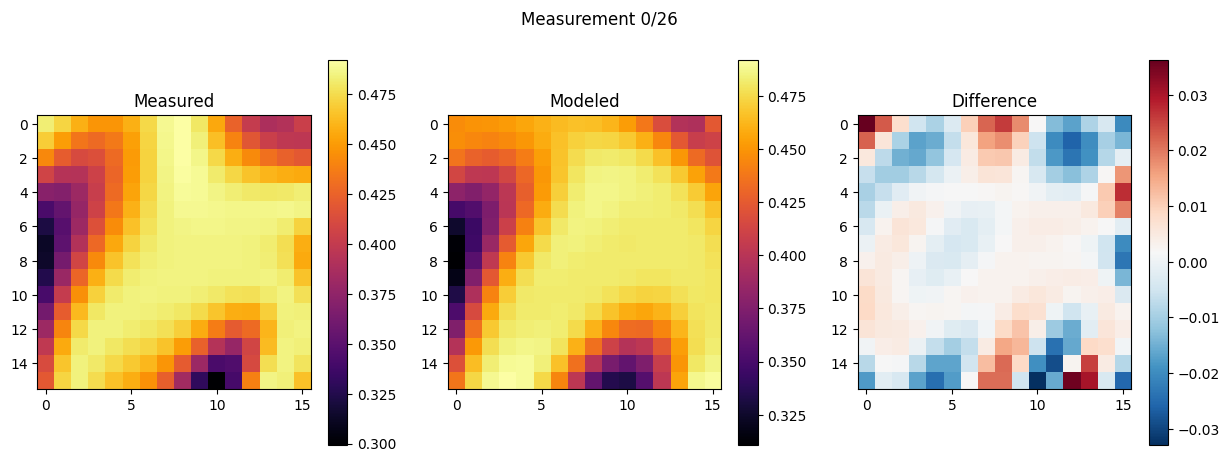

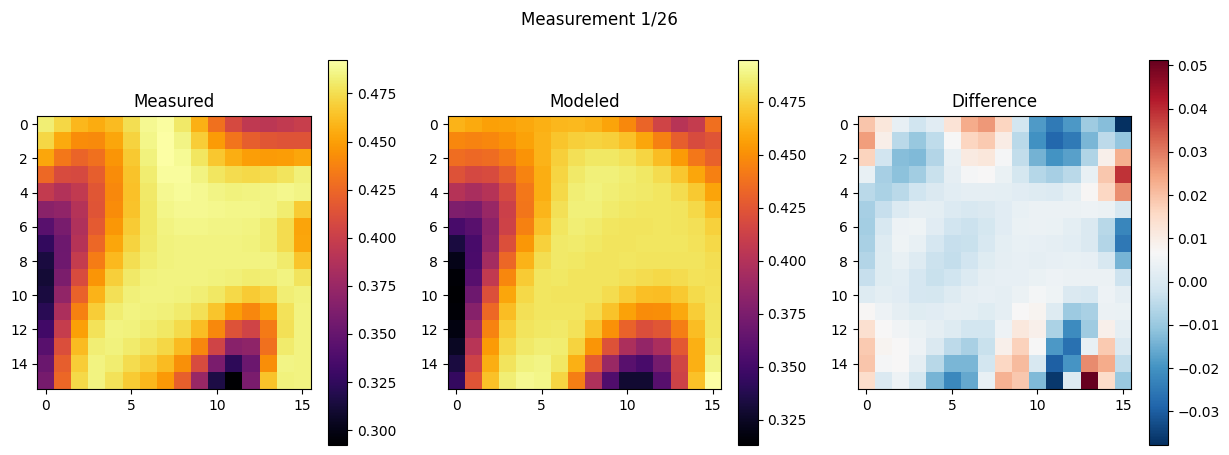

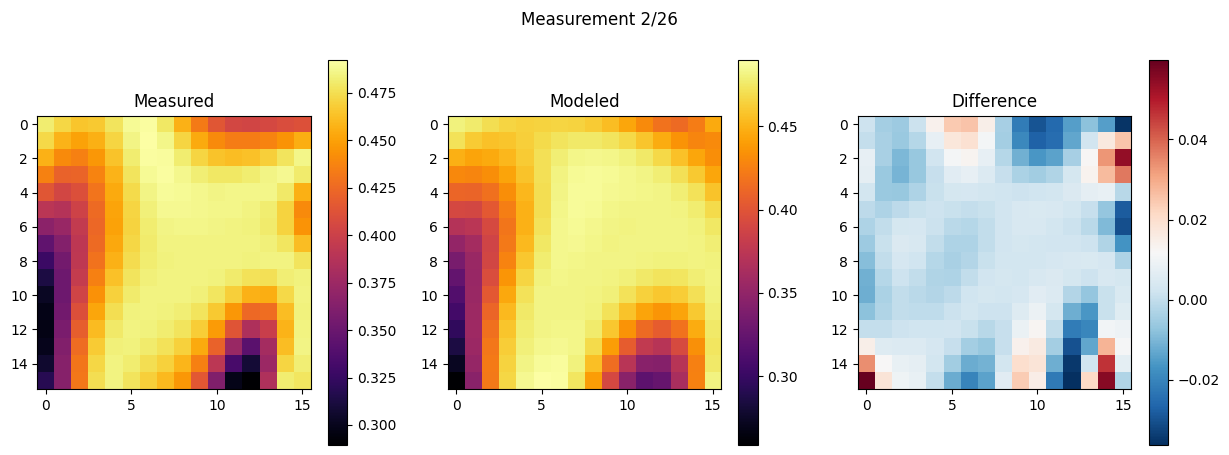

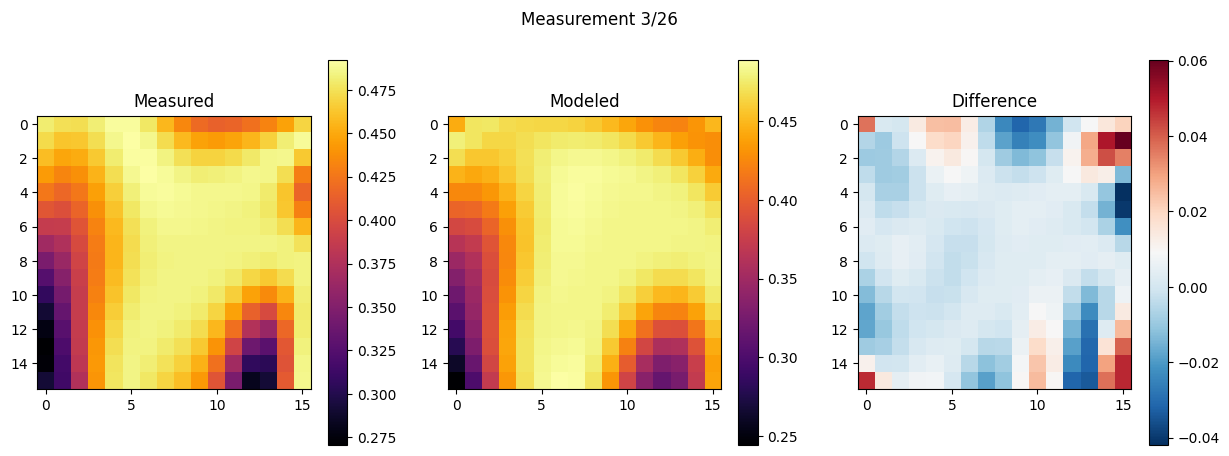

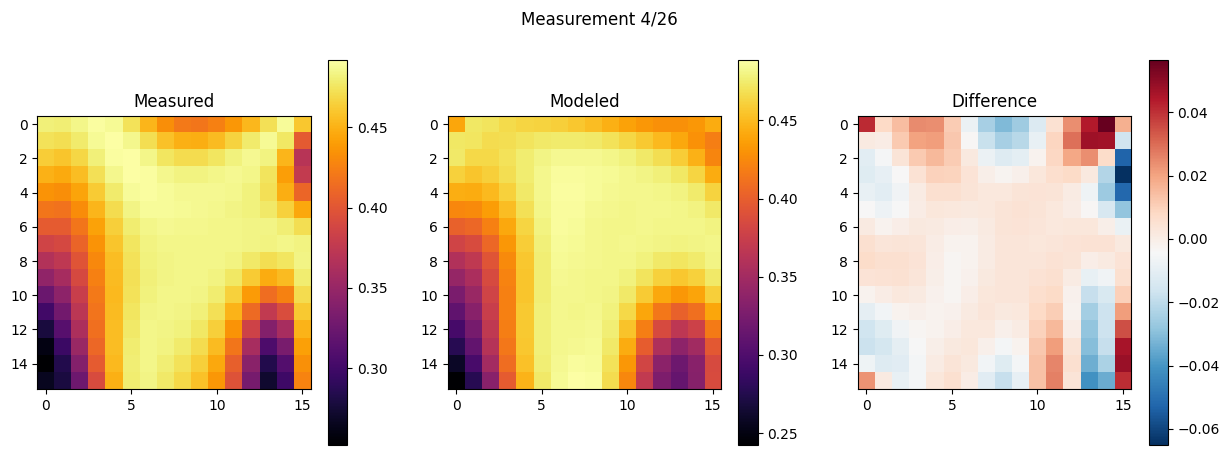

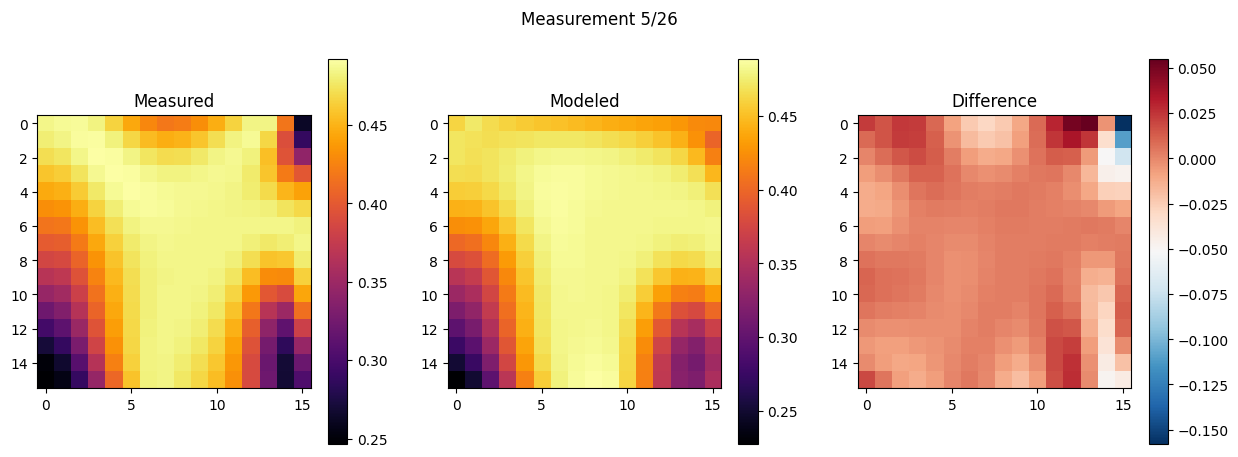

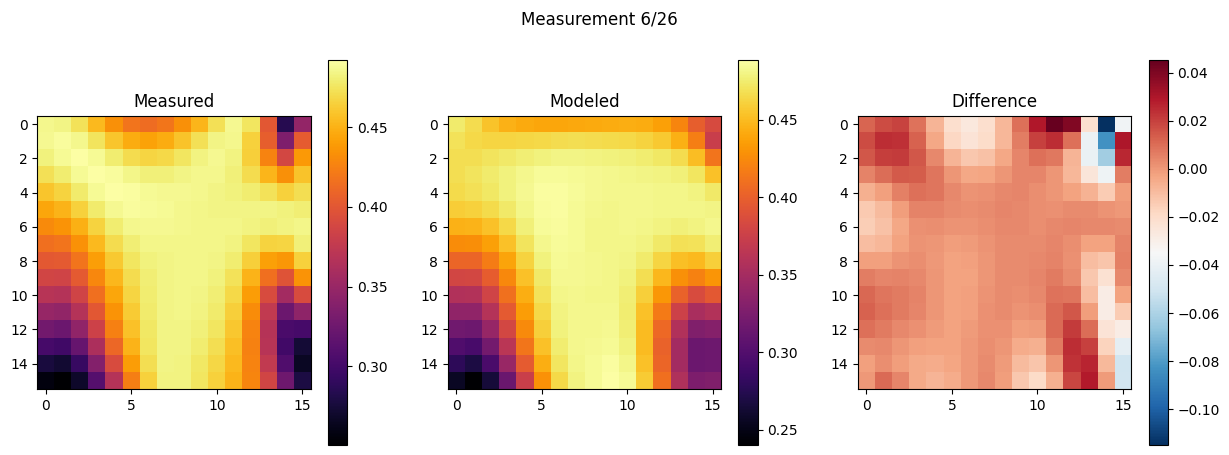

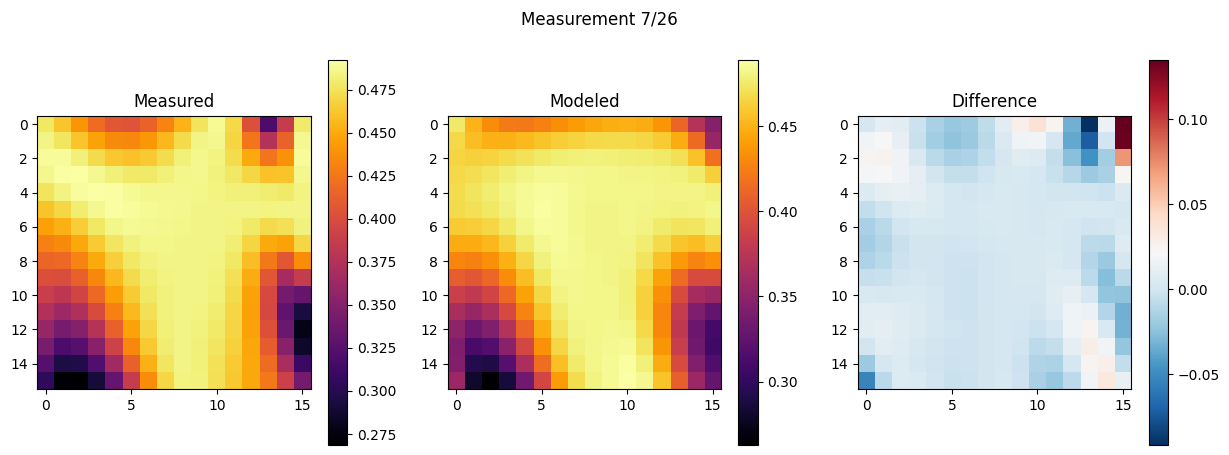

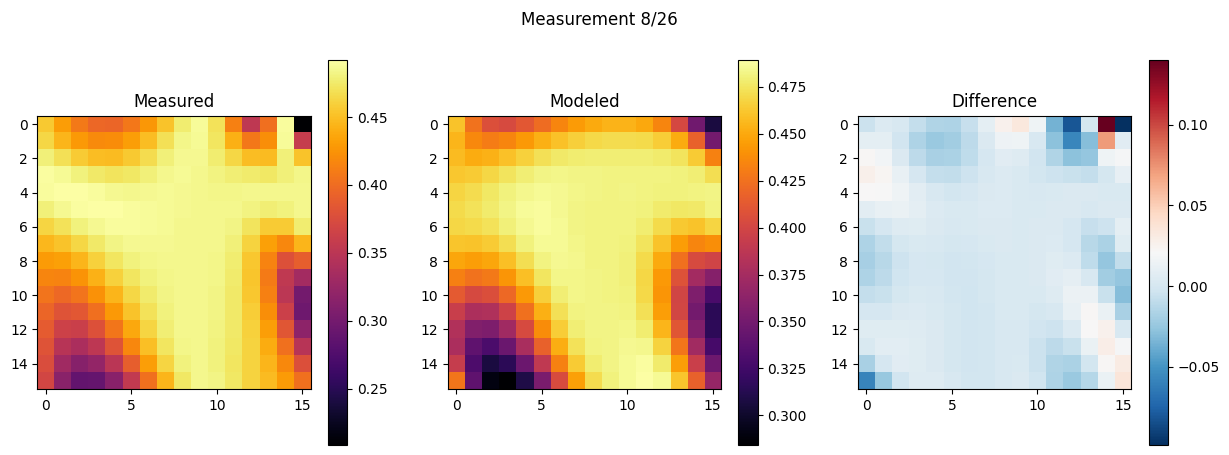

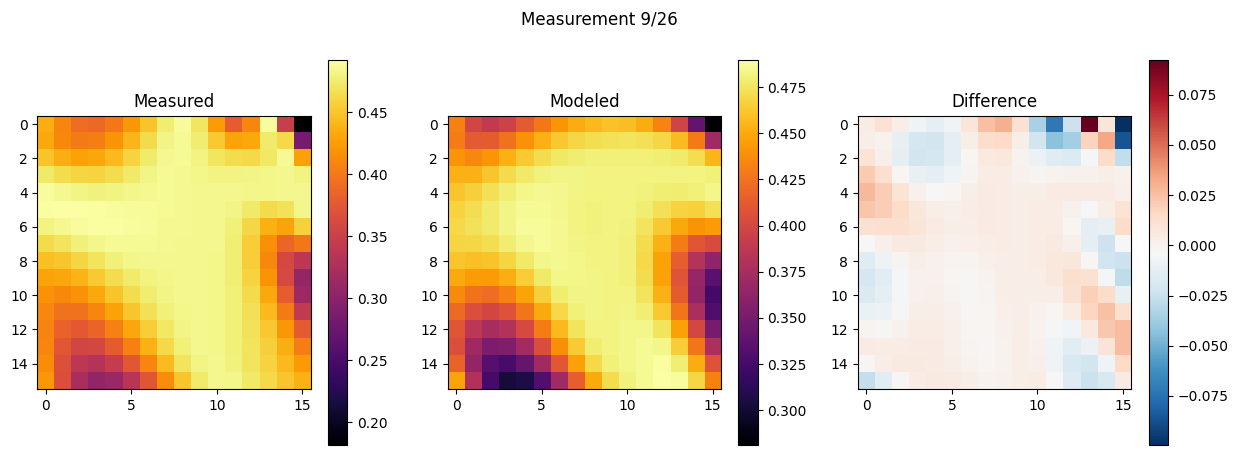

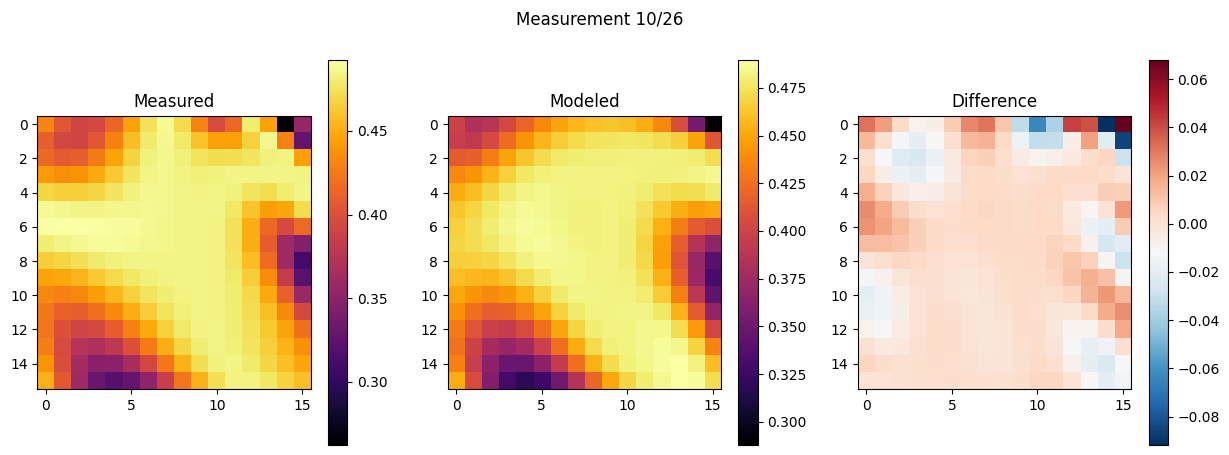

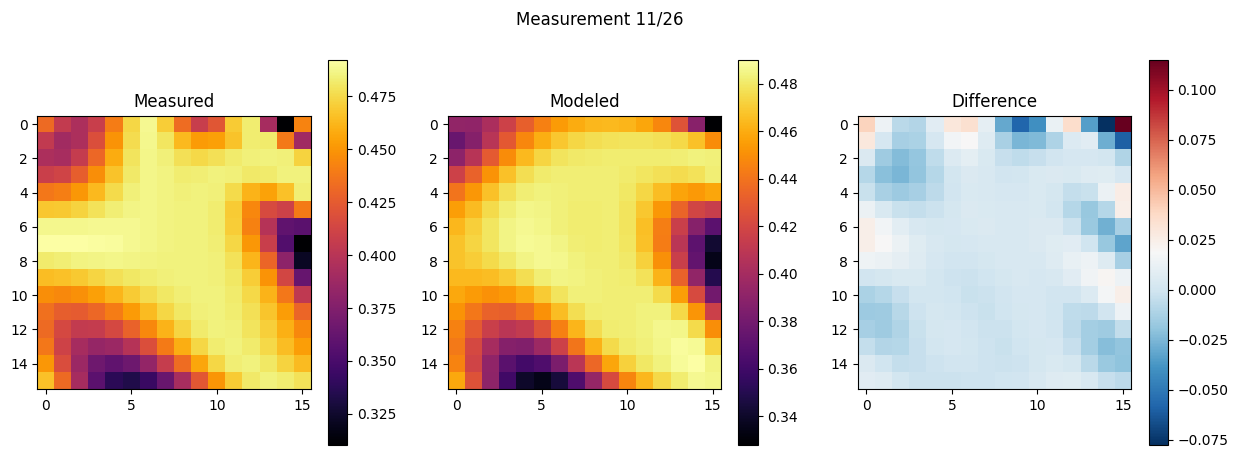

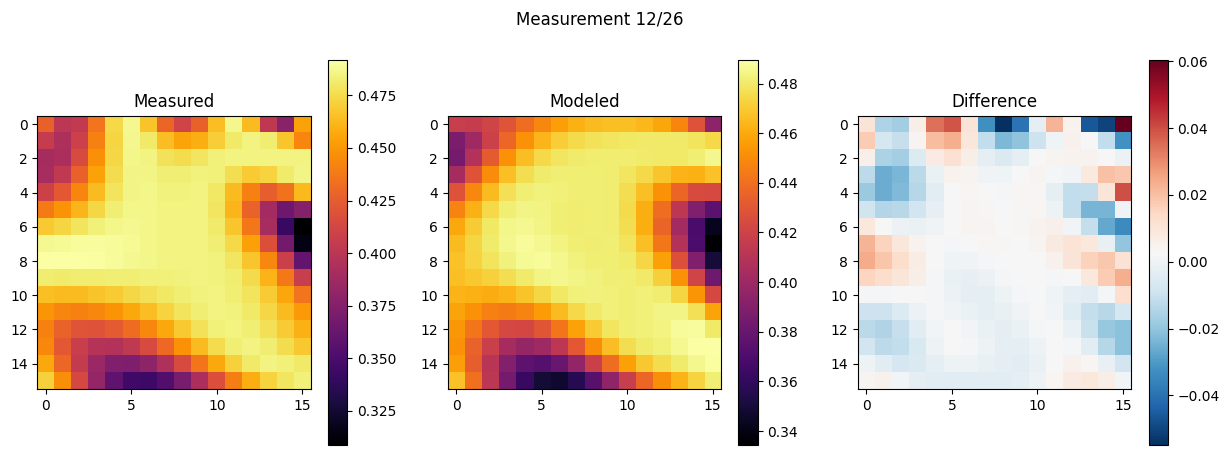

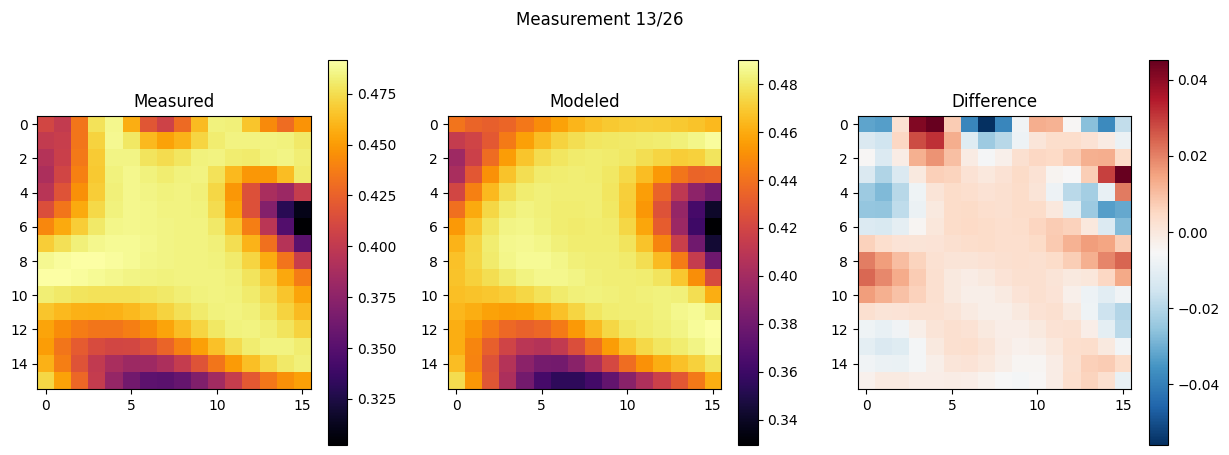

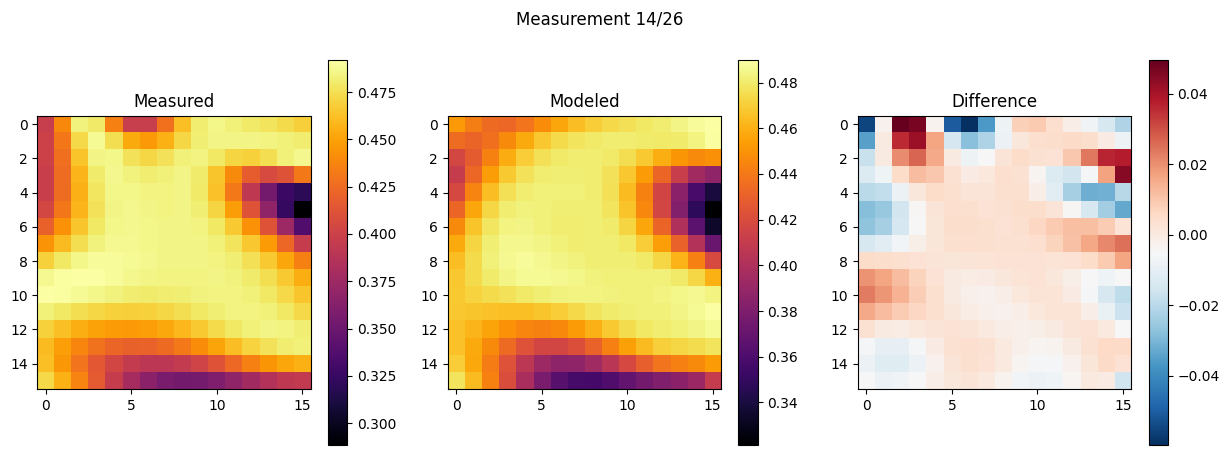

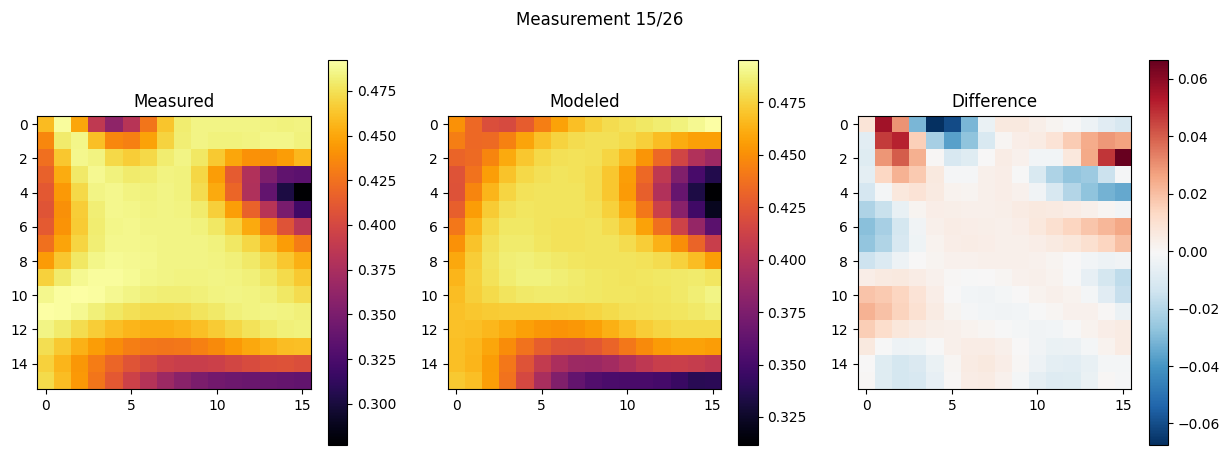

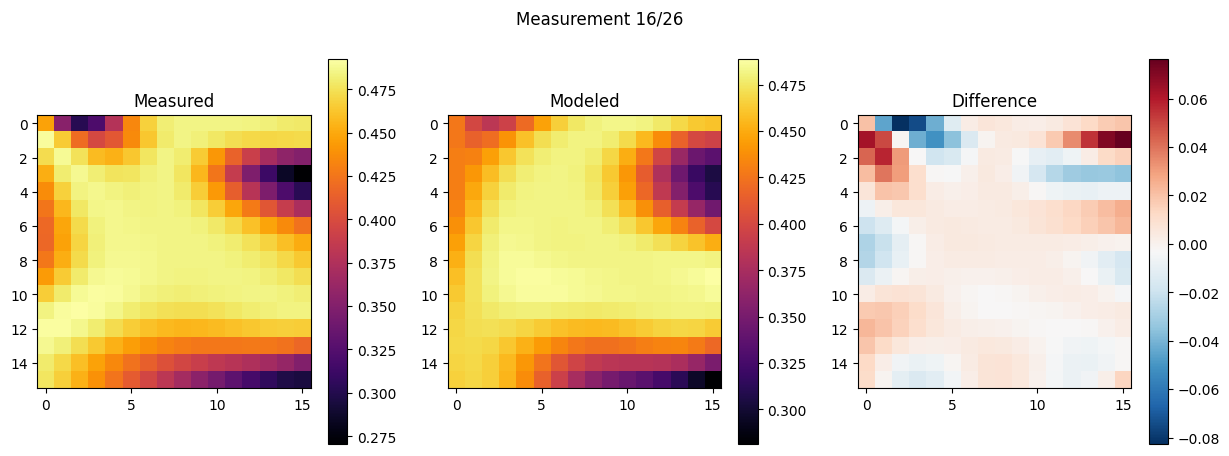

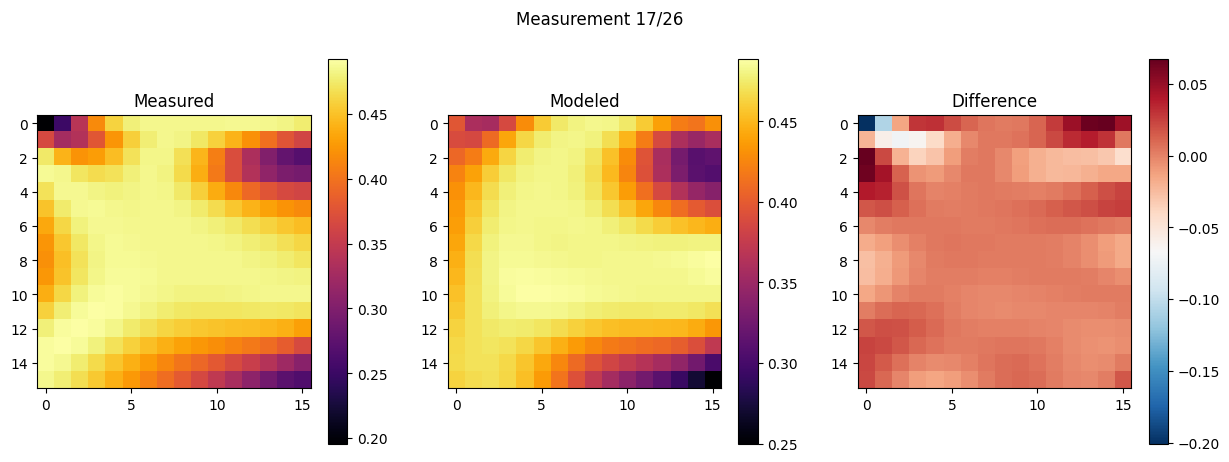

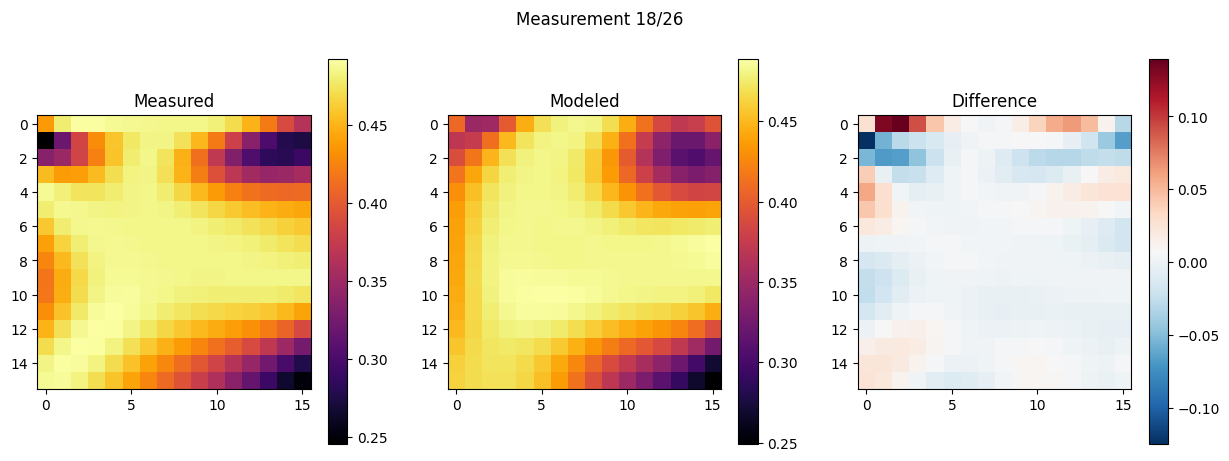

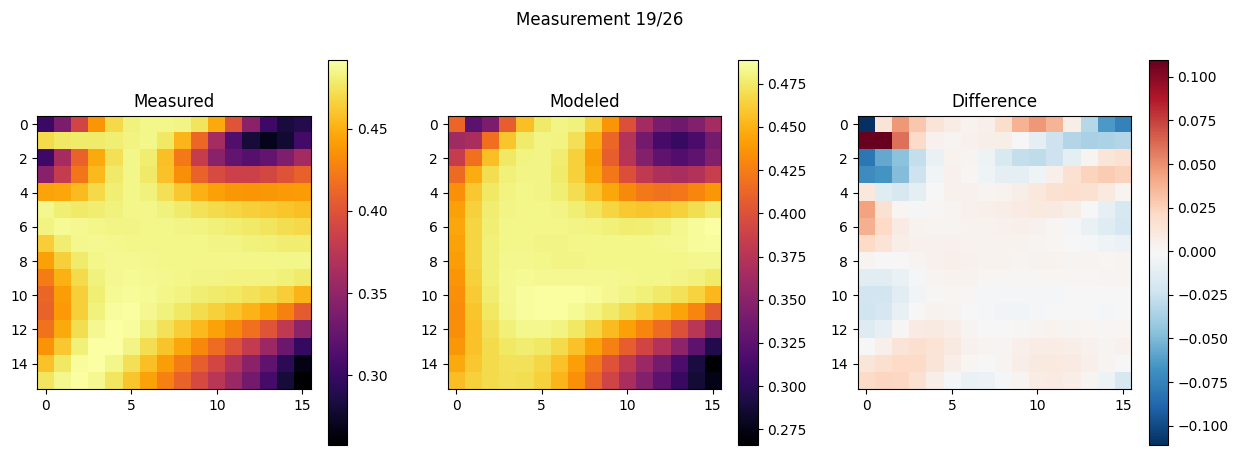

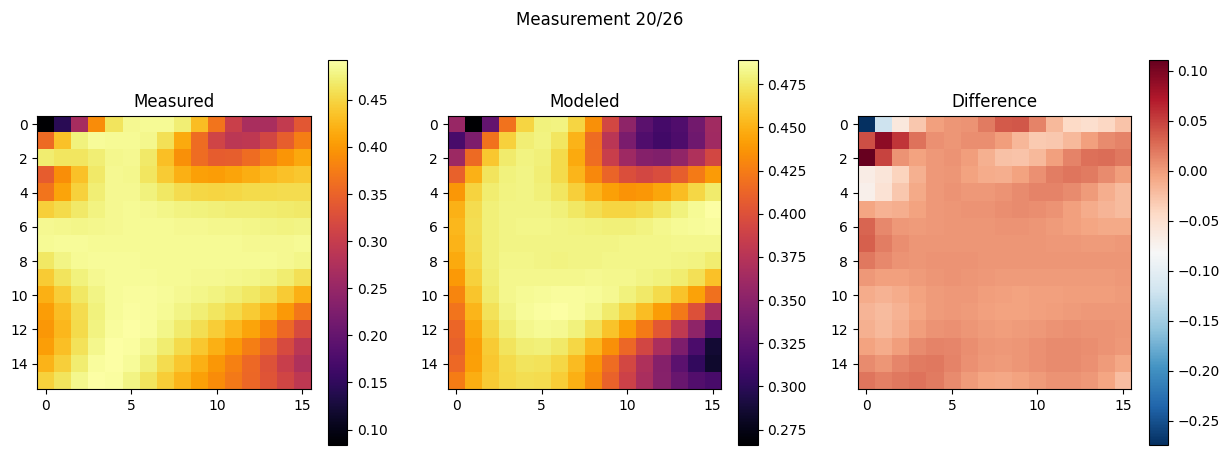

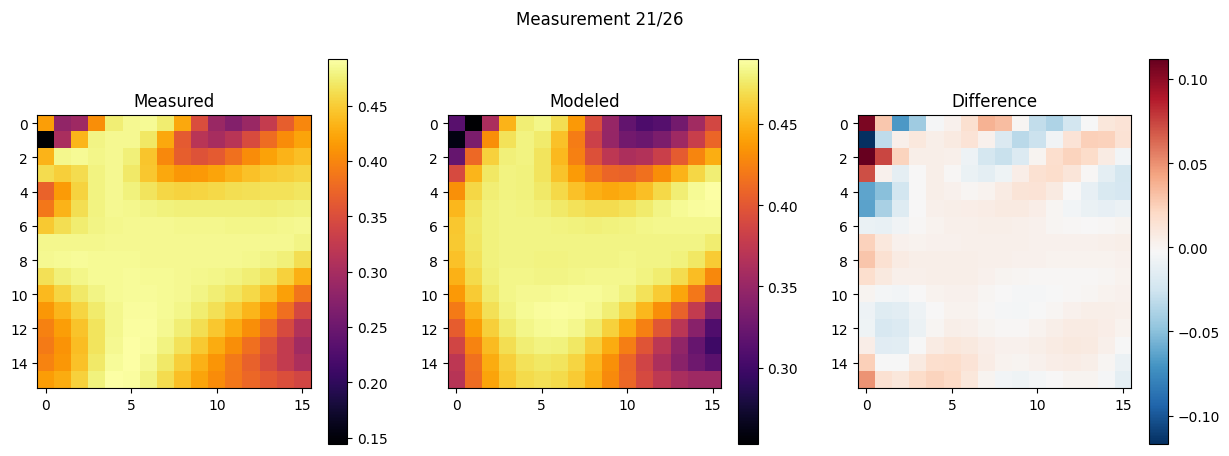

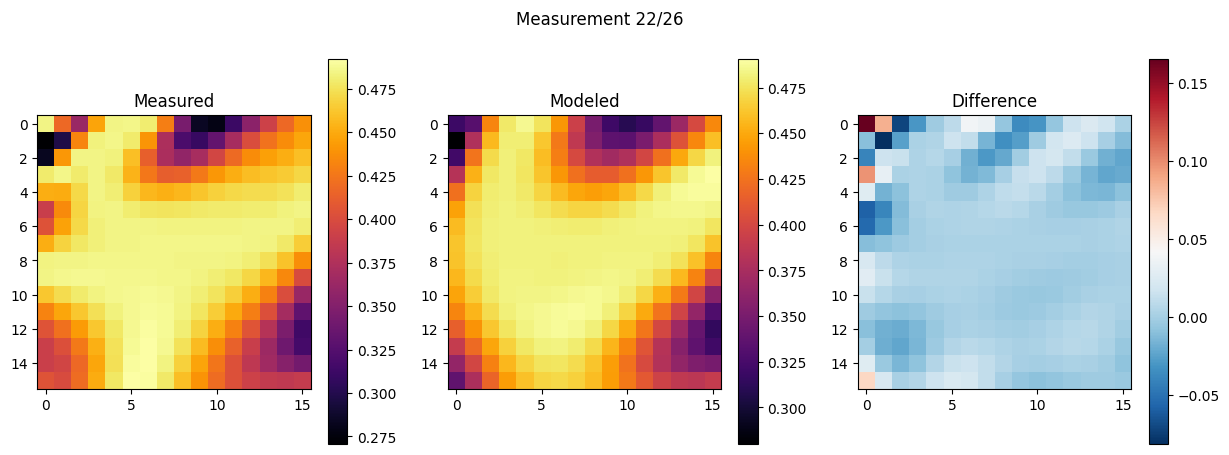

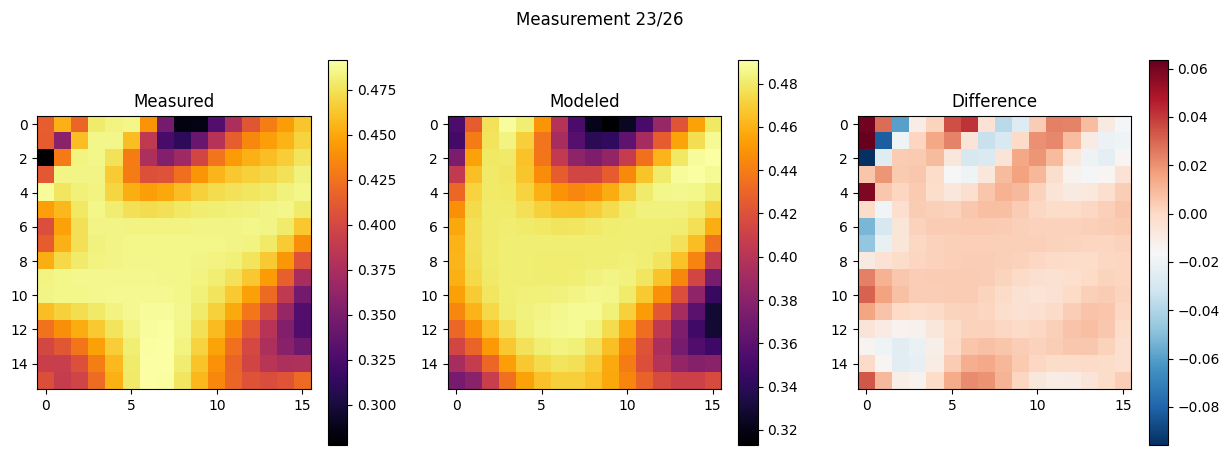

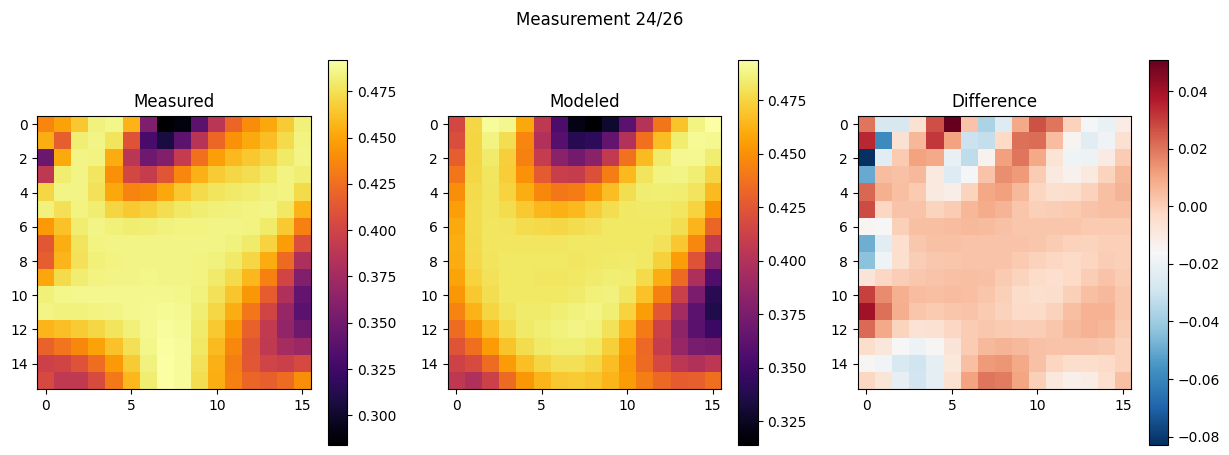

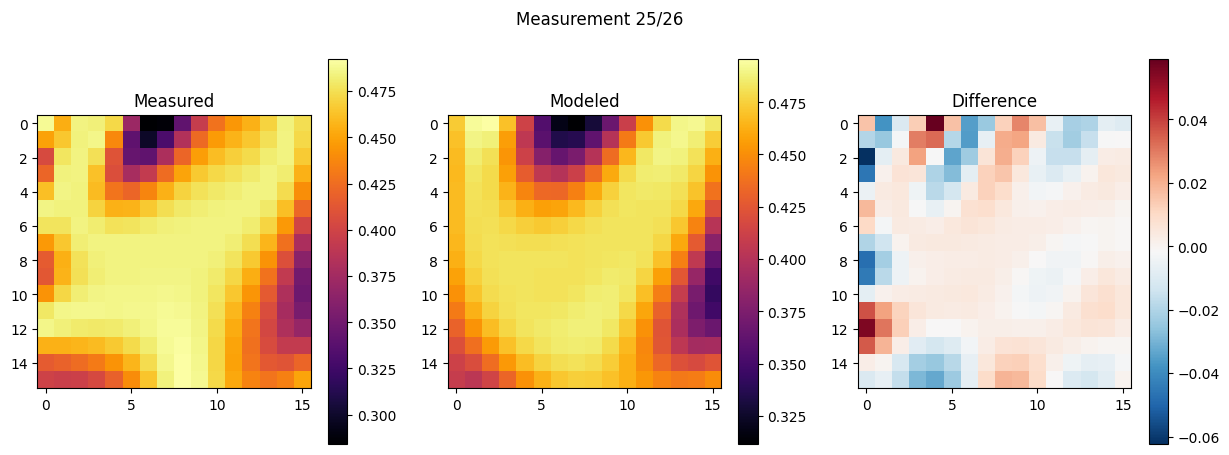

In [27]:
power_modeled = forward_simulate(results.x)

for i in range(NMEAS):
    plt.figure(figsize=[15,5])
    plt.suptitle(f"Measurement {i}/{NMEAS}")
    plt.subplot(131)
    plt.title("Measured")
    plt.imshow(power_experiment[..., i], cmap='inferno')
    plt.colorbar()
    plt.subplot(132)
    plt.title("Modeled")
    plt.imshow(power_modeled[..., i], cmap='inferno')
    plt.colorbar()
    plt.subplot(133)
    plt.title("Difference")
    plt.imshow(power_experiment[..., i] - power_modeled[..., i], cmap='RdBu_r')
    plt.colorbar()
    plt.show()